In [1]:
import ee

In [3]:
ee.Authenticate()

True

In [4]:
import geemap
import geemap.plot as plot

In [5]:
ee.Initialize(project='localsolve')

In [6]:
map = geemap.Map()
map.setCenter(-118.288105,34.172376,10)

In [7]:
#geometry = ee.Geometry.Polygon([(-118.951721, 32.75004), (-118.951721, 34.823302), (-117.646374, 34.823302), (-117.646374, 32.75004)])
coords = [[[-118.68851840411794,34.02132960959575],[-118.49488437091482,34.02132960959575],[-118.49488437091482,34.1413272361762],[-118.68851840411794,34.1413272361762]]]
area = ee.Geometry.Polygon(coords)

In [8]:
def mask_clouds(image):
    # Get the cloud mask from the QA60 band
    qa = image.select('QA60')
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)  # Bit 10 is clouds
    return image.updateMask(cloud_mask).divide(10000)  # Scale to reflectance

In [9]:
#point = ee.Geometry.Rectangle([-118.87381926259474,33.676536492962484,-117.42191790156431,34.44541483548236])
#point = point_new.buffer(5000000)  # 5 km buffer around the point
sentinel_prefire = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area).filterDate('2024-12-10','2025-01-06').sort('CLOUD_COVERAGE_ASSESSMENT').map(mask_clouds).median()
sentinel_postfire = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area).filterDate('2025-01-07','2025-01-18').sort('CLOUD_COVERAGE_ASSESSMENT').map(mask_clouds).median()


#print(f"Pre-fire images available: {pre_sentinel}")
#print(f"Post-fire images available: {post_sentinel}")

In [10]:
# Debugging image availability
pre_sentinel_count = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(area) \
    .filterDate('2024-01-07', '2025-01-18') \
    .size() \
    .getInfo()

post_sentinel_count = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(area) \
    .filterDate('2024-12-10', '2025-01-06') \
    .size() \
    .getInfo()

print(f"Pre-fire images available: {pre_sentinel_count}")
print(f"Post-fire images available: {post_sentinel_count}")

Pre-fire images available: 78
Post-fire images available: 6


In [11]:
vis_par = {
    'min':0,
    'max':3000,
    'bands':['B4','B3','B2']
  }
map.addLayer(sentinel_prefire,vis_par, 'Sentinel_prefire')
map.addLayer(sentinel_postfire,vis_par, 'Sentinel_postfire')

In [12]:
#ndvi = image.normalizedDifference(['B8','B4'])

In [13]:
vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

In [14]:
pre = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area).filterDate('2024-12-15','2025-01-06').sort('CLOUD_COVERAGE_ASSESSMENT').map(mask_clouds).median()#median() #.sort('CLOUD_COVERAGE_ASSESSMENT').first
post = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area).filterDate('2025-01-07','2025-01-18').sort('CLOUD_COVERAGE_ASSESSMENT').map(mask_clouds).median()#median()

In [15]:
pre_burn = pre.reproject(crs='EPSG:4326', scale =10)
post_burn = post.reproject(crs='EPSG:4326', scale =10)
# 10 meters resolution
#pre_burn.getInfo()
#post_burn.getInfo()

In [16]:
B12 = pre_burn.select('B12')  # SWIR-2
B8a = pre_burn.select('B8A')  # Narrow NIR
B3 = pre_burn.select('B3')    # Green
B2 = pre_burn.select('B2')    # Blue

In [17]:
b12 = post_burn.select('B12')  # SWIR-2
b8a = post_burn.select('B8A')  # Narrow NIR
b3 = post_burn.select('B3')    # Green
b2 = post_burn.select('B2')    # Blue

In [18]:
num = B12.subtract(B8a).subtract(B3).subtract(B2)
denom = B12.add(B8a).add(B3).add(B2)

In [19]:
numerator = b12.subtract(b8a).subtract(b3).subtract(b2)
denominator = b12.add(b8a).add(b3).add(b2)

In [20]:
nbr_plus_pre = num.divide(denom).rename('nbr_plus_pre')
nbr_plus_post = numerator.divide(denominator).rename('nbr_plus_post')

In [21]:
print("NBR+ calculated:", nbr_plus_pre.getInfo())
print("NBR+ calculated:", nbr_plus_post.getInfo())

NBR+ calculated: {'type': 'Image', 'bands': [{'id': 'nbr_plus_pre', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, 0, 0, -8.983152841195215e-05, 0]}]}
NBR+ calculated: {'type': 'Image', 'bands': [{'id': 'nbr_plus_post', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, 0, 0, -8.983152841195215e-05, 0]}]}


In [22]:
net_nbr = nbr_plus_pre.subtract(nbr_plus_post).rename('net_nbr')
net_nbr.getInfo()


{'type': 'Image',
 'bands': [{'id': 'net_nbr',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [8.983152841195215e-05,
    0,
    0,
    0,
    -8.983152841195215e-05,
    0]}]}

In [23]:
varis = {
    'min': -1,
    'max': 1,
    'palette': ['green', 'white', 'red']
}

In [24]:
map.addLayer(net_nbr, varis, 'Net NBR')
map.addLayer(nbr_plus_pre, varis, 'NBR+ pre')
map.addLayer(nbr_plus_post, varis, 'NBR+ post')

In [25]:
print(nbr_plus_post.bandNames().getInfo())
print(nbr_plus_pre.bandNames().getInfo())

['nbr_plus_post']
['nbr_plus_pre']


In [26]:
# Combine pre- and post-fire NBR into a single image
combined_image = nbr_plus_pre.addBands(nbr_plus_post)


In [27]:
#Define thresholds for burn severity
burn_severity = combined_image.expression(
    "b('nbr_plus_pre') - b('nbr_plus_post') > 0.66 ? 7 : "  # High severity
    "b('nbr_plus_pre') - b('nbr_plus_post') > 0.44 ? 6 : " # Moderate high severity
    "b('nbr_plus_pre') - b('nbr_plus_post') > 0.27 ? 5 : " # Moderate Low severity
    "b('nbr_plus_pre') - b('nbr_plus_post') > 0.10 ? 4 : " #Low
    "b('nbr_plus_pre') - b('nbr_plus_post') > -0.10 ? 3 : " #Unburned
    "b('nbr_plus_pre') - b('nbr_plus_post') > -0.25 ? 2 : " # Enhanced regrowth low
    "1",  # Enhanced regrowth low
    {
        'nbr_plus_pre': nbr_plus_pre,
        'nbr_plus_post': nbr_plus_post
    }
).rename('BurnSeverity')#

# Visualization parameters for burn severity
burn_vis = {
    'min': 1,
    'max': 7,
    'palette': ['green', 'lightgreen', 'yellow', 'orange', 'red', 'brown', 'black']
}

# Add the burn severity layer to the map
map.addLayer(burn_severity, burn_vis, 'Burn Severity')


In [28]:
# Define thresholds for burn severity
burn_severity = net_nbr.expression(
    "b('net_nbr') > 0.66 ? 7 : " +  # High severity
    "b('net_nbr') > 0.44 ? 6 : " +  # Moderate high severity
    "b('net_nbr') > 0.27 ? 5 : " +  # Moderate low severity
    "b('net_nbr') > 0.10 ? 4 : " +  # Low
    "b('net_nbr') > -0.10 ? 3 : " +  # Unburned
    "b('net_nbr') > -0.25 ? 2 : " +  # Enhanced regrowth low
    "1",  # Enhanced regrowth high
    {
        'net_nbr': net_nbr
    }
).rename('BurnSeverity')

# Visualization parameters for burn severity
burn_vis = {
    'min': 1,
    'max': 7,
    'palette': ['green', 'lightgreen', 'yellow', 'orange', 'red', 'brown', 'black']
}

# Add the burn severity layer to the map
map.addLayer(burn_severity, burn_vis, 'Burn Severity')  # Use 'burn_severity' here, not 'net_nbr'


In [29]:
# Calculate dNBR (Difference in NBR) from the pre- and post-fire NBR
dNBR = nbr_plus_pre.subtract(nbr_plus_post)
roi= ee.Geometry.Rectangle([-118.87381926259474,33.676536492962484,-117.42191790156431,34.44541483548236])
# Calculate the min and max values for dNBR
dNBR_min_max = dNBR.reduceRegion(
    reducer=ee.Reducer.minMax(),  # To get both min and max values
    geometry= roi,
    scale=30,                     # Set the scale (adjust based on the image's resolution)
    maxPixels=1e8                 # Optionally adjust to avoid data truncation for large images
)

# Print the min and max dNBR values
print(dNBR_min_max.getInfo())

{'nbr_plus_pre_max': 0.8084547321467896, 'nbr_plus_pre_min': -1.5345048058388178}


In [30]:
map

Map(center=[34.172376, -118.288105], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [31]:
burn_severity.getInfo()

{'type': 'Image',
 'bands': [{'id': 'BurnSeverity',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 7},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [32]:
asset_id = 'projects/localsolve/assets/los_angeles_fires/LATrees'

In [33]:
trees = ee.FeatureCollection(asset_id)

In [34]:
first_feature = trees.first()
column_names = first_feature.propertyNames()
print(column_names.getInfo())

['pine', 'ispalm', 'camphor', 'jacaranda', 'crepemyrtl', 'magnolia', 'mexfanpalm', 'species', 'ash', 'oak', 'id', 'place', 'category', 'system:index']


In [ ]:
# For Palisades fire
#coords = [[[-118.68851840411794,34.02132960959575],[-118.49488437091482,34.02132960959575],[-118.49488437091482,34.1413272361762],[-118.68851840411794,34.1413272361762]]]
#area = ee.Geometry.Polygon(coords)

In [37]:
# For Eaton fire
coords = [[[-118.16629769267233,34.15489244566532],[-118.00836922587546,34.15489244566532],[-118.00836922587546,34.247176857557854],[-118.16629769267233,34.247176857557854]]]
area = ee.Geometry.Polygon(coords)

In [38]:
subset_tree = trees.filterBounds(area)

In [39]:
map.addLayer(subset_tree, {}, 'Trees')

In [40]:
# Extract values at points
sampled_data = burn_severity.sampleRegions(
    collection=subset_tree,
    scale=10,
    geometries = True,
)

In [41]:
trees_intersect = sampled_data.filter(ee.Filter.gte('BurnSeverity',4))

In [42]:
# Export the sampled data to Google Drive (optional)
task = ee.batch.Export.table.toDrive(
    collection=trees_intersect,
    description='Eaton_LATreeswithburn',
    fileFormat='CSV'
)
task.start()

In [43]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon

from matplotlib import pyplot as plt
import seaborn as sns

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
palisades_trees_withburn = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Palisades_LATreeswithburn.csv")
palisades_trees_withburn

,system:index,BurnSeverity,ash,camphor,category,crepemyrtl,id,ispalm,jacaranda,magnolia,mexfanpalm,oak,pine,place,species,.geo
0,0001000000000001513c_0,4,True,False,ash,False,446704,False,False,False,False,False,False,Los Angeles City,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,000100000000000138cd_0,4,True,False,ash,False,424011,False,False,False,False,False,False,Santa Monica,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,0001000000000000067d_0,4,False,True,camphor,False,12554,False,False,False,False,False,False,Los Angeles City,Camphor Tree,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,00010000000000004d6a_0,4,False,True,camphor,False,144937,False,False,False,False,False,False,Los Angeles City,Camphor Tree,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,00010000000000004f0c_0,4,False,True,camphor,False,148171,False,False,False,False,False,False,Los Angeles City,Camphor Tree,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,000100000000000209aa_0,4,False,False,pine,False,1593276,False,False,False,False,False,True,Santa Monica,Torrey Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2131,000100000000000209b2_0,4,False,False,pine,False,1593317,False,False,False,False,False,True,Santa Monica,Torrey Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2132,00010000000000022bb1_0,4,False,False,pine,False,1208496,False,False,False,False,False,True,Santa Monica,Torrey Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2133,0001000000000000042a_0,4,False,False,pine,False,5301,False,False,False,False,False,True,Santa Monica,Yew Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [47]:
eaton_trees_withburn = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Eaton_LATreeswithburn.csv")
eaton_trees_withburn

,system:index,BurnSeverity,ash,camphor,category,crepemyrtl,id,ispalm,jacaranda,magnolia,mexfanpalm,oak,pine,place,species,.geo
0,00020000000000016dda_0,4,True,False,ash,False,440535,False,False,False,False,False,False,Los Angeles County,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,00020000000000016dde_0,4,True,False,ash,False,440547,False,False,False,False,False,False,Los Angeles County,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,00020000000000016f94_0,4,True,False,ash,False,443622,False,False,False,False,False,False,Los Angeles County,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,00020000000000005eeb_0,4,False,True,camphor,False,145374,False,False,False,False,False,False,Los Angeles County,Camphor,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,00020000000000005ef8_0,4,False,True,camphor,False,145390,False,False,False,False,False,False,Los Angeles County,Camphor,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,000300000000000300ad_0,4,False,False,pine,False,1435409,False,False,False,False,False,True,Pasadena,Canary Island Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1281,000300000000000300af_0,4,False,False,pine,False,1435415,False,False,False,False,False,True,Pasadena,Canary Island Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1282,0003000000000000e897_0,4,False,False,pine,False,292189,False,False,False,False,False,True,Pasadena,Japanese Black Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1283,0003000000000000e898_0,4,False,False,pine,False,292191,False,False,False,False,False,True,Pasadena,Japanese Black Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [50]:
trees_withburn = pd.concat([palisades_trees_withburn, eaton_trees_withburn], axis = 0).reset_index()
trees_withburn

,index,system:index,BurnSeverity,ash,camphor,category,crepemyrtl,id,ispalm,jacaranda,magnolia,mexfanpalm,oak,pine,place,species,.geo
0,0,0001000000000001513c_0,4,True,False,ash,False,446704,False,False,False,False,False,False,Los Angeles City,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,000100000000000138cd_0,4,True,False,ash,False,424011,False,False,False,False,False,False,Santa Monica,Shamel Ash,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,0001000000000000067d_0,4,False,True,camphor,False,12554,False,False,False,False,False,False,Los Angeles City,Camphor Tree,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,00010000000000004d6a_0,4,False,True,camphor,False,144937,False,False,False,False,False,False,Los Angeles City,Camphor Tree,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,00010000000000004f0c_0,4,False,True,camphor,False,148171,False,False,False,False,False,False,Los Angeles City,Camphor Tree,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,1280,000300000000000300ad_0,4,False,False,pine,False,1435409,False,False,False,False,False,True,Pasadena,Canary Island Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3416,1281,000300000000000300af_0,4,False,False,pine,False,1435415,False,False,False,False,False,True,Pasadena,Canary Island Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3417,1282,0003000000000000e897_0,4,False,False,pine,False,292189,False,False,False,False,False,True,Pasadena,Japanese Black Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3418,1283,0003000000000000e898_0,4,False,False,pine,False,292191,False,False,False,False,False,True,Pasadena,Japanese Black Pine,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [54]:
trees_withburn.groupby(['BurnSeverity','category'])['category'].count()


BurnSeverity  category    
4             ash                6
              camphor          116
              crepe myrtle      37
              jacaranda         50
              magnolia         362
              oak              325
              other           1759
              palm             467
              pine             240
5             magnolia           5
              oak                2
              other             32
              palm               3
              pine              13
6             pine               3
Name: category, dtype: int64

In [75]:
byseverity = trees_withburn.groupby(['BurnSeverity','category'])['species'].count().reset_index()
byseverity = byseverity.sort_values('species', ascending=False)
byseverity

,BurnSeverity,category,species
6,4,other,1756
7,4,palm,467
4,4,magnolia,362
5,4,oak,325
8,4,pine,240
1,4,camphor,116
3,4,jacaranda,50
2,4,crepe myrtle,37
11,5,other,32
13,5,pine,13


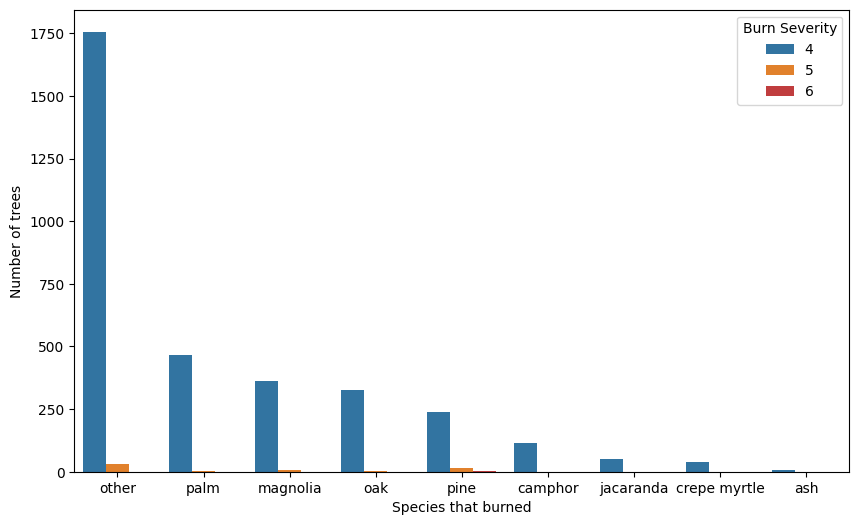

In [92]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# use the scatterplot() function
sns.barplot(
    x="category", # the x column
    y="species", # the y column
    hue="BurnSeverity", # the third dimension (color)
    data=byseverity,# pass in the data
    palette=sns.color_palette(["#1f77b4","#ff7f0e", "#D62728"]),
    ax=ax
)

# Format with matplotlib commands
ax.set_xlabel("Species that burned")
ax.set_ylabel("Number of trees")
# Change legend labels
ax.legend(title='Burn Severity', loc='upper right')